<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/rf%2Bderivedfeatures%2BXGBoostw_earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas rasterio scikit-learn xgboost matplotlib scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 66.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import geopandas as gpd
import rasterio
from rasterio.mask import mask

In [ ]:

# Load shapefile
habitat_gdf = gpd.read_file("/content/Ballymore_habitat_map2018_ITM.shp")

# Load RGB image
rgb_src = rasterio.open("/content/RGB.tif")


In [ ]:
#Clip Image & Align CRS
habitat_gdf = habitat_gdf.to_crs(rgb_src.crs)
geoms = habitat_gdf.geometry.values
rgb_clipped, rgb_transform = mask(rgb_src, geoms, crop=True)

bands, height, width = rgb_clipped.shape


In [ ]:
import numpy as np
# Extract RGB bands
R = rgb_clipped[0].astype(float)
G = rgb_clipped[1].astype(float)
B = rgb_clipped[2].astype(float)

# Compute indices
brightness = (R + G + B) / 3
rg_ratio = R / (G + 1e-6)
gb_ratio = G / (B + 1e-6)
ndi = (G - R) / (G + R + 1e-6)

# Stack indices
indices_stack = np.stack([brightness, rg_ratio, gb_ratio, ndi], axis=0)

In [ ]:
from skimage.feature import graycomatrix, graycoprops

# Convert to grayscale
gray = ((R + G + B) / 3).astype(np.uint8)

# Compute GLCM for a small window (e.g., 3x3)
window_size = 3
pad = window_size // 2
texture_features = []

for i in range(pad, gray.shape[0]-pad):
    row_features = []
    for j in range(pad, gray.shape[1]-pad):
        patch = gray[i-pad:i+pad+1, j-pad:j+pad+1]
        glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        row_features.append([contrast, homogeneity, energy, correlation])
    texture_features.append(row_features)

texture_features = np.array(texture_features)

In [ ]:
#combine features

# Flatten RGB and indices
rgb_flat = rgb_clipped.reshape((3, -1)).T
indices_flat = indices_stack.reshape((4, -1)).T

# Flatten texture features
texture_flat = texture_features.reshape((-1, 4))

# Combine all features
X_enhanced = np.hstack([rgb_flat, indices_flat, texture_flat])


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 225760 and the array at index 1 has size 169320

In [ ]:
from rasterio.features import rasterize

habitat_gdf['habitat_code'] = habitat_gdf['Habitat'].astype('category').cat.codes
label_mapping = dict(enumerate(habitat_gdf['Habitat'].astype('category').cat.categories))

habitat_raster = rasterize(
    [(geom, value) for geom, value in zip(habitat_gdf.geometry, habitat_gdf['habitat_code'])],
    out_shape=(height, width),
    transform=rgb_transform,
    fill=-1,
    dtype='int16'
)

habitat_labels = habitat_raster.flatten()
mask_valid = habitat_labels >= 0
X_train = X[mask_valid]
y_train = habitat_labels[mask_valid]

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Split data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_enhanced, y_train, test_size=0.2, random_state=42)

dtrain_split = xgb.DMatrix(X_train_split, label=y_train_split)
dval_split = xgb.DMatrix(X_val_split, label=y_val_split)

params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train)),
    'eval_metric': 'mlogloss',
    'max_depth': 10,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

xgb_model = xgb.train(
    params,
    dtrain_split,
    num_boost_round=1000,
    evals=[(dtrain_split, 'train'), (dval_split, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=50
)

NameError: name 'X_enhanced' is not defined

Validation Accuracy: 0.3688210906771553

Classification Report:
                                                                      precision    recall  f1-score   support

                                            Calluna - Eriophorum bog       0.58      0.46      0.51      2903
                                    Carex-Menyanthes transition mire       0.28      0.32      0.30      3083
                                        Filipendula-Holcus community       0.30      0.32      0.31      2436
                                             Juncus subnodulosus fen       0.20      0.19      0.20      1430
Mosaic Carex-Menyanthes transition mire/Filipendula-Holcus community       0.26      0.07      0.11      1897
                           Mosaic Schoenus-Carex fen/Menyanthes pool       0.40      0.61      0.49      4177
                                   Mosaic Ulex scrub/Molinia cutaway       0.19      0.02      0.04      1340
                                          Mosaic scrub/

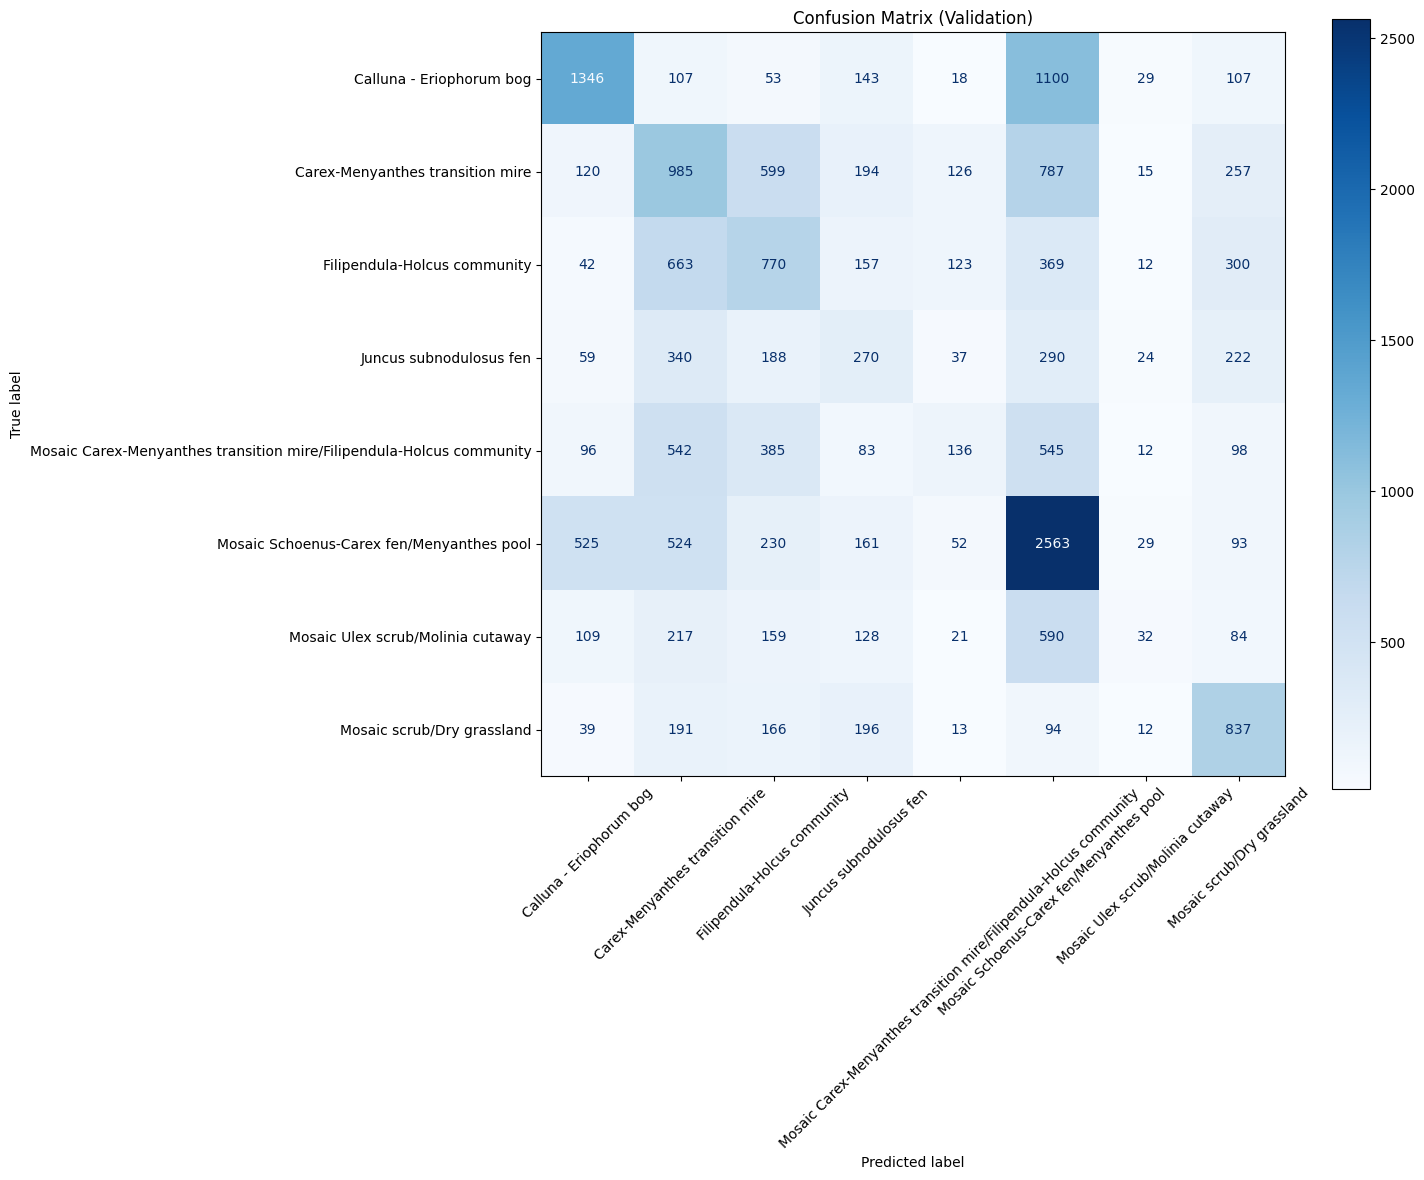

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_val_pred = xgb_model.predict(dval)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=list(label_mapping.values())))

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation)")
plt.show()